# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=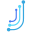)](https://jvelezmagic.com/)

![Curso de Manejo de Datos Faltantes: Exploración](course-logo.jpg)

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [3]:
%run pandas-missing-extension.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [4]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [6]:
airquality_df = (
    sm.datasets.get_rdataset('airquality')
    .data
    .clean_names(
        case_type = 'snake'
    )
    .add_column(
        'year', 1973
    )
    .assign(
        date = lambda df : pd.to_datetime(df[['year', 'month', 'day']])
    )
    .sort_values(by='date')
    .set_index('date')

)

airquality_df

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [8]:
(
    smf.ols(
        formula='temp ~ ozone',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)  ## notemos que todo funciono muy bien a pesar de que la variable zono tenia  valores faltantes
   ## sin embargo, no estamos viendo directamente el problema con los nans

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Thu, 11 Apr 2024",Prob (F-statistic):,2.93e-18
Time:,14:03:07,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [9]:
(
    smf.ols(
        formula='temp ~ ozone + solar_r',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)  ## notemos que en realidad estamos perdiendo filas, ya que son 153, y son 111
   ## los lagoritmos estan descartando los nans, entonces por eso hay que estar atento
   ## para utlilizar todos los datos, vamos a imputar esos nans, para no perder info

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Thu, 11 Apr 2024",Prob (F-statistic):,1.47e-16
Time:,14:04:48,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [26]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [27]:

survival_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,age,0,7874,0.000000
1,sex,0,7874,0.000000
2,sample.yr,0,7874,0.000000
3,kappa,0,7874,0.000000
4,lambda,0,7874,0.000000
5,flc.grp,0,7874,0.000000
6,creatinine,1350,7874,17.145034
7,mgus,0,7874,0.000000
8,futime,0,7874,0.000000
9,death,0,7874,0.000000


In [24]:
survival_df.select_dtypes(object).select_dtypes(object).apply(pd.unique)['chapter']

array(['Circulatory', 'Neoplasms', 'Mental', 'Nervous', 'Respiratory',
       'Digestive', nan, 'Injury and Poisoning', 'External Causes',
       'Genitourinary', 'Ill Defined', 'Infectious', 'Blood', 'Endocrine',
       'Musculoskeletal', 'Skin', 'Congenital'], dtype=object)

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [31]:
(
    smf.ols(
        data=survival_df,
        formula='death ~ age + C(chapter) + C(sex)'
    )
    .fit()
    .summary()
    .tables[0]
)

## Notemos que al agregar la variable chapter, categorica, que tienen muchos nans, causa un 
## R2 de -inf

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-126.5
Date:,"Thu, 11 Apr 2024",Prob (F-statistic):,1.00
Time:,14:15:36,Log-Likelihood:,70737.
No. Observations:,2169,AIC:,-1.414e+05
Df Residuals:,2151,BIC:,-1.413e+05
Df Model:,17,,
Covariance Type:,nonrobust,,


## Preparando datos: _National Health and Nutrition Examination Survey_

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


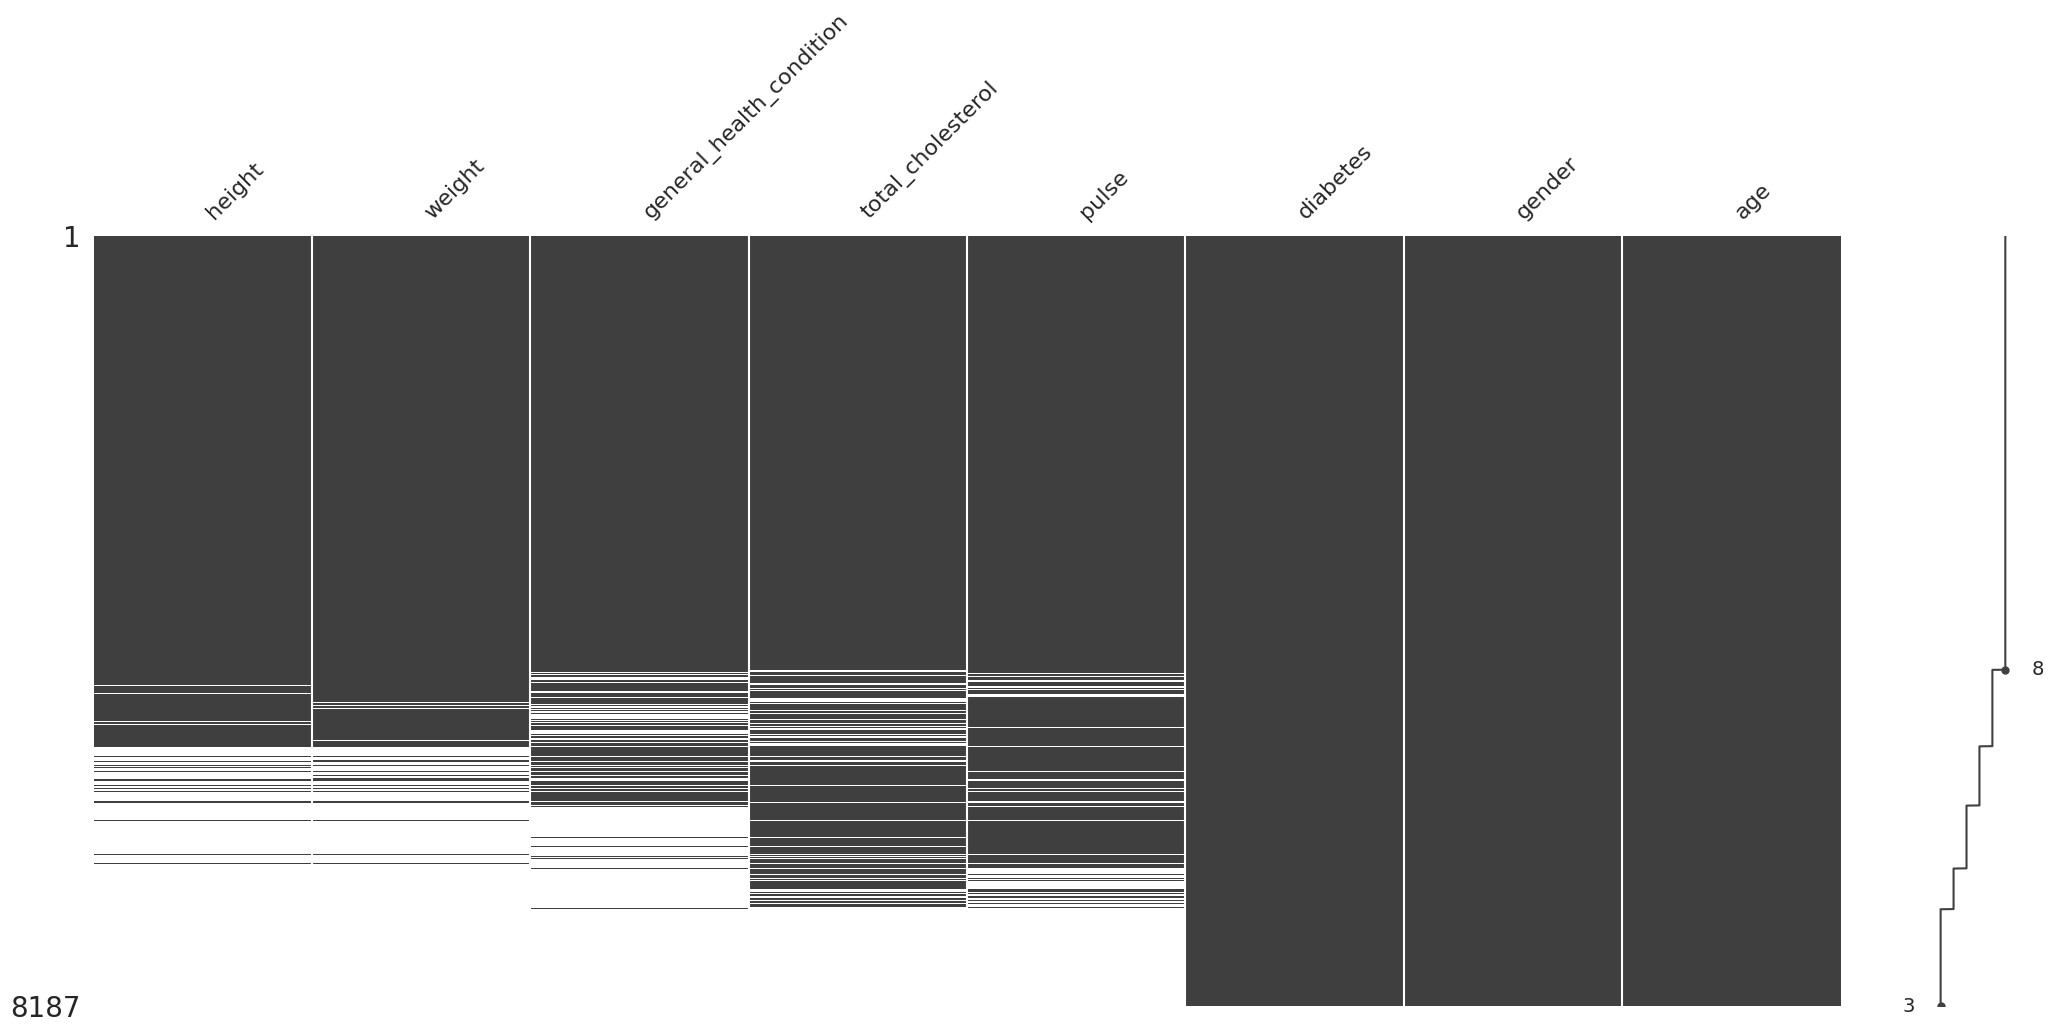

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work beca

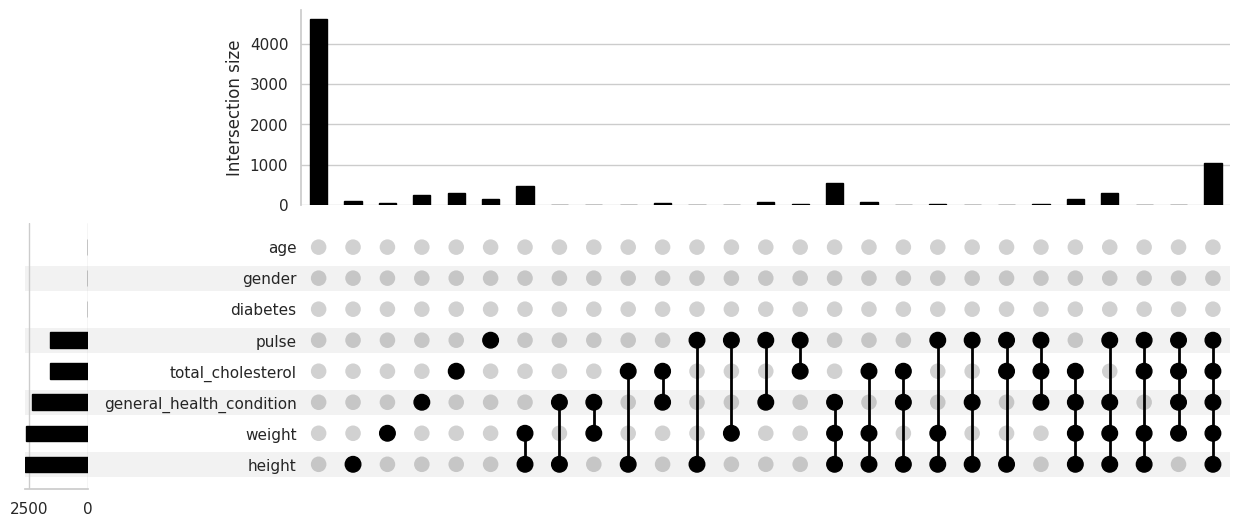

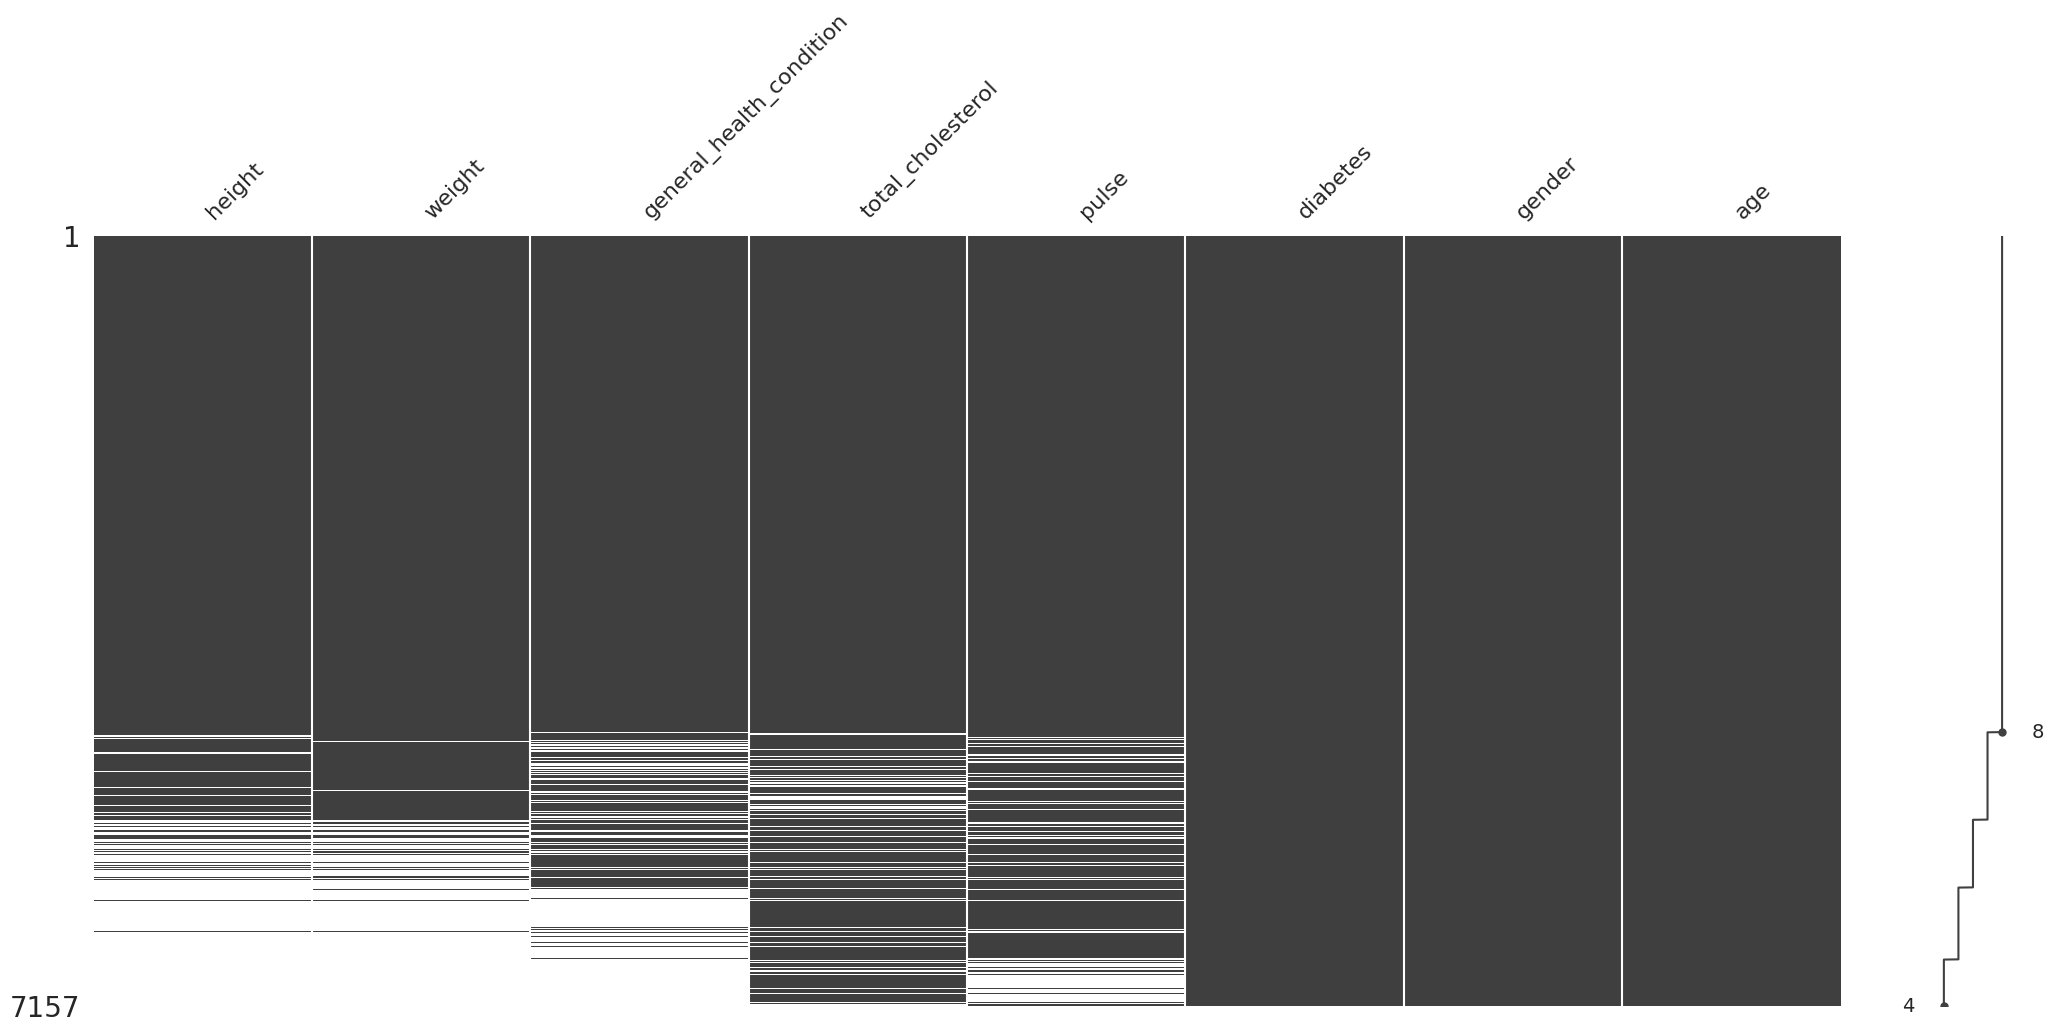

In [32]:
%run download-data-and-load-it.ipynb

---

## Consideración y evaluación de los distintos tipos de valores faltantes

![](missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

Prueba T y Prueba Z
Suponiendo que se hayan cumplido los supuestos de que los datos esten distribuidos normalmente y que ambas muestras tengan varianzas iguales, es posible usar la prueba t student para muestras grandes. Cuando n > 30, la distribucion t se aproxima a la distribucion normal y lo mas relevante es que la infuencia de los grados de libertad en la forma de la distribucion gradualmente se vuelve nula. Es por ello que ningun paquete estadistico establece una regla para elegir entre la prueba t y la prueba z. La prueba t se propuso para superar la incapacidad de la prueba z para muestras pequeñas pero esto no quiere decir que no aplique tambien para muestras grandes. En cambio, la prueba t gana mas poder cuando el tamaño de la muestra se hace cada vez mas grande

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

El t-test, o prueba t de Student, es una herramienta estadística utilizada para comparar las medias de dos grupos y determinar si hay una diferencia significativa entre ellas. Hay diferentes variantes del t-test, y las opciones "two-sided" (de dos lados), "less" (menor) y "greater" (mayor) se refieren a la dirección de la diferencia que se está evaluando. Aquí hay una explicación para cada caso:  

Two-sided (de dos lados):
Hipótesis nula (H0): No hay diferencia significativa entre las medias de los dos grupos.
Hipótesis alternativa (H1): Hay una diferencia significativa entre las medias de los dos grupos, ya sea que una sea mayor o menor que la otra.
En este caso, la prueba evalúa si hay evidencia suficiente para rechazar la hipótesis nula en favor de la hipótesis alternativa, independientemente de la dirección de la diferencia.  

Less (menor):
Hipótesis nula (H0): La media del primer grupo es mayor o igual que la del segundo grupo.
Hipótesis alternativa (H1): La media del primer grupo es significativamente menor que la del segundo grupo.
Esta opción se utiliza cuando se tiene una hipótesis específica sobre la dirección de la diferencia, y estás interesado en determinar si la media de un grupo es significativamente menor que la del otro.  

Greater (mayor):
Hipótesis nula (H0): La media del primer grupo es menor o igual que la del segundo grupo.
Hipótesis alternativa (H1): La media del primer grupo es significativamente mayor que la del segundo grupo.
Similar a "less", esta opción se utiliza cuando se tiene una hipótesis específica sobre la dirección de la diferencia, y estás interesado en determinar si la media de un grupo es significativamente mayor que la del otro.

* Tuve que preguntarle a ChatGPT porque no entendí bien el tema, pero ahora me ha quedado claro:

El código realiza una prueba t-test independiente usando la función ttest_ind del módulo scipy.stats. La prueba t-test comparará la media de dos grupos de datos y determinará si existe una diferencia significativa entre ellos.

El primer argumento a es el primer grupo de datos (female_weight) y el segundo argumento b es el segundo grupo de datos (male_weight).

El argumento alternative especifica el tipo de hipótesis nula a probar, en este caso "two-sided" indica que se está realizando una prueba two-tailed, es decir, se está investigando si existe una diferencia significativa entre las dos medias, sin importar en qué dirección.

El resultado es el valor estadístico y el valor p del test t-test independiente entre dos grupos "female_weight" y "male_weight". La hipótesis nula es que la media de ambos grupos es igual.

El valor p obtenido es de 0.717, lo que sugiere que no hay suficiente evidencia para rechazar la hipótesis nula. Por lo tanto, no se puede concluir que la media de los dos grupos sea diferente.

El valor absoluto del estadístico t, 0.362, es bajo, lo que indica que las diferencias entre los dos grupos son poco significativas.

In [40]:
female_weight, male_weight = (
    nhanes_df
    .select_columns('gender','weight')
    .transform_column(
        'weight',
        lambda x: x.isna(),
        elementwise=False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df: (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)
scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative='two-sided'
)   

# El resultado es el valor estadístico y el valor p del test t-test independiente entre dos grupos "female_weight" y "male_weight". 
# La hipótesis nula es que la media de ambos grupos es igual.

# El valor p obtenido es de 0.717, lo que sugiere que no hay suficiente evidencia para rechazar la hipótesis nula. 
# Por lo tanto, no se puede concluir que la media de los dos grupos sea diferente.

# El valor absoluto del estadístico t, 0.362, es bajo, lo que indica que las diferencias entre los dos grupos son poco significativas.

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


TtestResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239, df=7155.0)

## Amplía tu conjunto de herramientas para explorar valores faltantes

In [41]:
## Como explorar el conjunto de varibales categoricas en cuesrtion de la ausencia de otra variables
(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender')
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )
)

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,weight,general_health_condition,gender
SEQN,,,
93705.0,!NA,Good,Female
93706.0,!NA,Very good,Male
93707.0,NA,Good,Male
93709.0,!NA,NaN,Female
93711.0,!NA,Very good,Male
...,...,...,...
102949.0,!NA,Excellent,Male
102953.0,!NA,Fair or,Male
102954.0,!NA,Good,Female


In [44]:
(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender')
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby(
        ['gender', 'general_health_condition', 'weight'],
        dropna=False,
        as_index=True
    ).size()
)

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


gender  general_health_condition  weight
Female  Excellent                 !NA        212
                                  NA          65
        Fair or                   !NA        549
                                  NA          42
        Good                      !NA       1102
                                  NA         113
        Poor?                     !NA         94
                                  NA           3
        Very good                 !NA        659
                                  NA         103
        NaN                       !NA        234
                                  NA         489
Male    Excellent                 !NA        273
                                  NA          62
        Fair or                   !NA        508
                                  NA          31
        Good                      !NA       1056
                                  NA         112
        Poor?                     !NA         70
                            

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


(<Figure size 1000x1000 with 3 Axes>,
 {('Female', 'Excellent', '!NA'): (0.0,
   0.0,
   0.38910692830200494,
   0.0743407957417306),
  ('Female', 'Excellent', 'NA'): (0.3902367251483326,
   0.0,
   0.11930165254542605,
   0.0743407957417306),
  ('Female', 'Fair or', '!NA'): (0.0,
   0.07761948426632075,
   0.47227802180243583,
   0.15861158947062376),
  ('Female', 'Fair or', 'NA'): (0.4734078186487635,
   0.07761948426632075,
   0.036130559044995084,
   0.15861158947062376),
  ('Female', 'Good', '!NA'): (0.0,
   0.23950976226153467,
   0.4611244906122378,
   0.3260796636325006),
  ('Female', 'Good', 'NA'): (0.4622542874585654,
   0.23950976226153467,
   0.04728409023519317,
   0.3260796636325006),
  ('Female', 'Poor?', '!NA'): (0.0,
   0.5688681144186255,
   0.4926846041201908,
   0.0260326974258046),
  ('Female', 'Poor?', 'NA'): (0.49381440096651846,
   0.5688681144186255,
   0.015723976727240133,
   0.0260326974258046),
  ('Female', 'Very good', '!NA'): (0.0,
   0.5981795003690202,


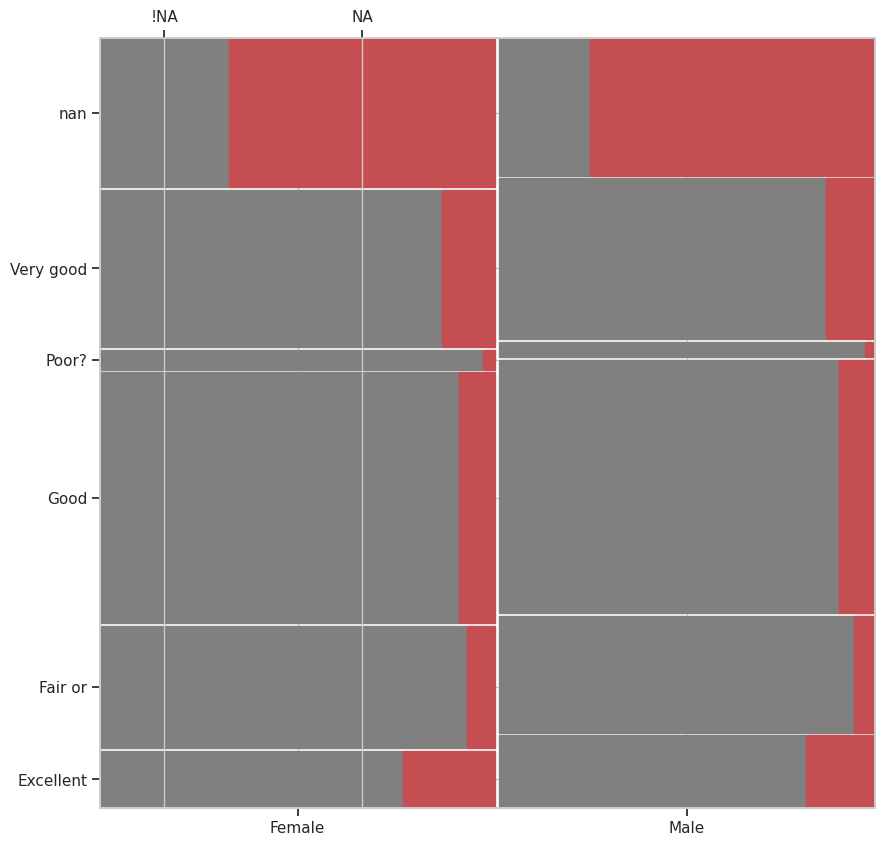

In [49]:
fig, ax = plt.subplots(figsize =(10,10))
   ### Se crea una TABLA DE CONSISTENCIA
(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender')
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby(
        ['gender', 'general_health_condition', 'weight'],
        dropna=False,
        as_index=True
    ).size()
    .pipe(
        lambda df : mosaic(
            data=df,
            properties = lambda key : {'color': 'r' if 'NA' in key else 'gray'},
            horizontal = True,
            axes_label=True,
            title='',
            labelizer = lambda key: '',
            ax = ax
        )
    )
)

## Tratamiento de variables categóricas para imputación de valores faltantes
La mayor parte de las variables categoricas son cadenas de textos y por tanto realizar operaciones con ellas no es trivial. Es asi como surge la necesidad de convertir o codificar las cadenas de texto a numeros de manera que los algoritmos puedan entenderlos o asociarlos

#### Codificacion Ordinal
Consiste en mapear cada elemento unico de texto a un numero entero. Una vez realizada la codificacion podemos comenzar el proceso de imputacion introduciendo los datos a un algoritmo de imputacion

In [52]:
nhanes_transform_df = nhanes_df.copy(deep=True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [53]:
X = [['Male'], ['Female'],['Female']]

In [54]:
encoder = sklearn.preprocessing.OrdinalEncoder()

In [55]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [56]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [58]:
encoder.inverse_transform([[1],[0],[1]])

array([['Male'],
       ['Female'],
       ['Male']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [62]:
categorical_columns = nhanes_df.select_dtypes(include=[object, 'category']).columns

In [73]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder='passthrough'
)

In [74]:
categorical_transformer.fit_transform(nhanes_df)

array([[  2.,   0.,  63., ...,  52.,   0.,  66.],
       [  4.,   1.,  68., ...,  82.,   0.,  18.],
       [  2.,   1.,  nan, ..., 100.,   0.,  13.],
       ...,
       [  2.,   0.,  66., ...,  78.,   0.,  41.],
       [  4.,   0.,  nan, ...,  74.,   0.,  14.],
       [  2.,   1.,  69., ...,  76.,   0.,  38.]])

In [75]:
(
    pd.DataFrame(
        categorical_transfromer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index

    )
    .rename_columns(
        function = lambda x : x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x : x.removeprefix('remainder__')
    )
)

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [ ]:
## FORMA DE HACERLO PARA UNA SOLA VARIABLE


# gender_encoder = sklearn.preprocessing.OrdinalEncoder()

# gender_values = (
#     nhanes_df
#     .gender
#     .values
#     .reshape(-1, 1)
# )

# (
#     gender_encoder
#     .fit_transform(
#         X = gender_values
#     )
#     .squeeze()
# )

# (
#     nhanes_df.gender.unique(),
#     nhanes_transformed_df.gender.unique(),
#     gender_encoder.categories_
# )

### _One Hot Encoding_
Consiste en crear una matriz de unos y ceros donde el 1 representa la presencia de una caracteristica o categoria de la variable de interes y 0 la ausencia de la misma. La lista se convierte en un formato ancho de manera que cada columna representa un elemento unico de nuesta categoria.

5-10-20 categorias → Ordinal encoding

100-1000-2000-3000 categorias → One Hot Encoding

Ordinal Encoder: El OrdinalEncoder se utiliza cuando existe un orden o jerarquía natural entre las categorías de una variable categórica. Esto significa que las categorías tienen una relación de orden y se pueden asignar valores numéricos que reflejen este orden. Algunos ejemplos de variables categóricas donde se puede aplicar el OrdinalEncoder son:
Niveles de educación: como "Primaria", "Secundaria", "Universidad", donde hay un orden lógico de menor a mayor nivel educativo.
Evaluaciones de rendimiento: como "Bajo", "Medio", "Alto", donde hay una escala ordinal de bajo a alto rendimiento.

One-Hot Encoder: El OneHotEncoder se utiliza cuando no existe un orden o jerarquía natural entre las categorías de una variable categórica, y se desea crear variables binarias para cada categoría. Esto permite representar cada categoría como una columna independiente, donde un valor de 1 indica la presencia de esa categoría y un valor de 0 indica la ausencia. Algunos ejemplos de variables categóricas donde se puede aplicar el OneHotEncoder son:
Colores: como "Rojo", "Verde", "Azul", donde cada color se representa como una columna separada en el conjunto de datos codificado en caliente.
Países: como "Estados Unidos", "Canadá", "México", donde cada país se representa como una columna separada indicando su presencia o ausencia.

In [77]:
nhanes_transform_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [80]:
(
    nhanes_transform_df2
    .select_columns('general_health_condition')
    .pipe(pd.get_dummies)
)

##Problema, en ocasiones no tener todas las categorias dificulta e get dummies, ya que no sabemos si
## se necesiten mas columnas en un futuro para nuevas categorias,  eso se ejemplifica, haciendo el 
## getdumies con un df head(10), ya que ahi solo habrán algunas categorias, y otras por descubir
##  El pd.getdummies es muy util,pero no cuando se necesita realizar operaciones con dimensionalidad cte.

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
93709.0,False,False,False,False,False
93711.0,False,False,False,False,True
...,...,...,...,...,...
102949.0,True,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


#### `skelearn.preprocessing.OneHotEncoder()`

In [86]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ['gender']),
    (sklearn.preprocessing.OneHotEncoder(), ['general_health_condition']),
    remainder = 'passthrough'
)

In [89]:
nhanes_transform_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index

    )
    .rename_columns(
        function = lambda x : x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x : x.removeprefix('remainder__')
    )

    .rename_columns(
        function = lambda x : x.removeprefix('onehotencoder__')
    )
)
nhanes_transform_df2

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [90]:
(
    transformer
    .named_transformers_
    .get(
        'onehotencoder'
    )
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [91]:
(
    transformer
    .named_transformers_
    .get(
        'onehotencoder'
    ).inverse_transform(
        X=[[0,0,0,1,0,0]]
    )
)

array([['Poor?']], dtype=object)

## Tipos de imputación de valores faltantes

* Que son las imputaciones basadas en Donantes?
Completa los valores que faltan para una unidad dada copiando los valores observados de otra unidad, el donante

* Que son las imputaciones con base en Modelos?
El objetivo es encontrar un modelo predictivo para cada variable objetivo en el conjunto de datos que contiene valores faltantes

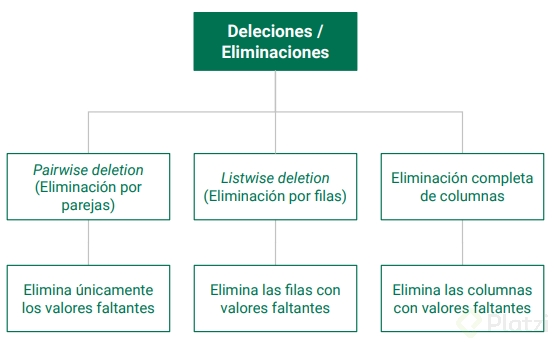

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

In [94]:
(
    nhanes_df
    ## Janitor
    .transform_column(
        'height',
        lambda x : x.fillna(x.mean()),
        elementwise = False    ### Para que sea para serie yh no para elemento
    )
)

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93705.0,63.00000,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.00000,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,66.25656,NaN,Good,189.0,100.0,0,Male,13.0
93709.0,62.00000,200.0,NaN,176.0,74.0,0,Female,75.0
93711.0,69.00000,142.0,Very good,238.0,62.0,0,Male,56.0
...,...,...,...,...,...,...,...,...
102949.0,72.00000,180.0,Excellent,201.0,96.0,0,Male,33.0
102953.0,65.00000,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.00000,150.0,Good,172.0,78.0,0,Female,41.0


/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


<Axes: xlabel='height', ylabel='weight'>

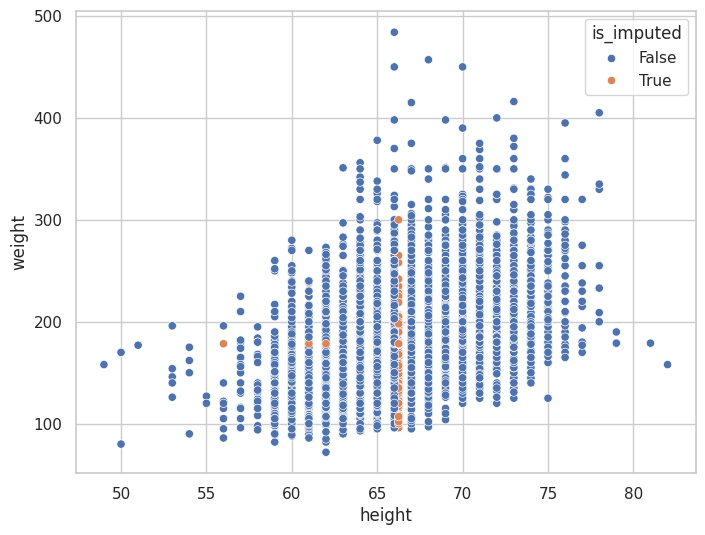

In [100]:
(
    nhanes_df
    .select_columns('height', 'weight')
    .missing.bind_shadow_matrix(True, False, suffix='_imp')
    .assign(
        height = lambda df : df.height.fillna(value= df.height.mean()),
        weight = lambda df : df.weight.fillna(value= df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight'
    )
)

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


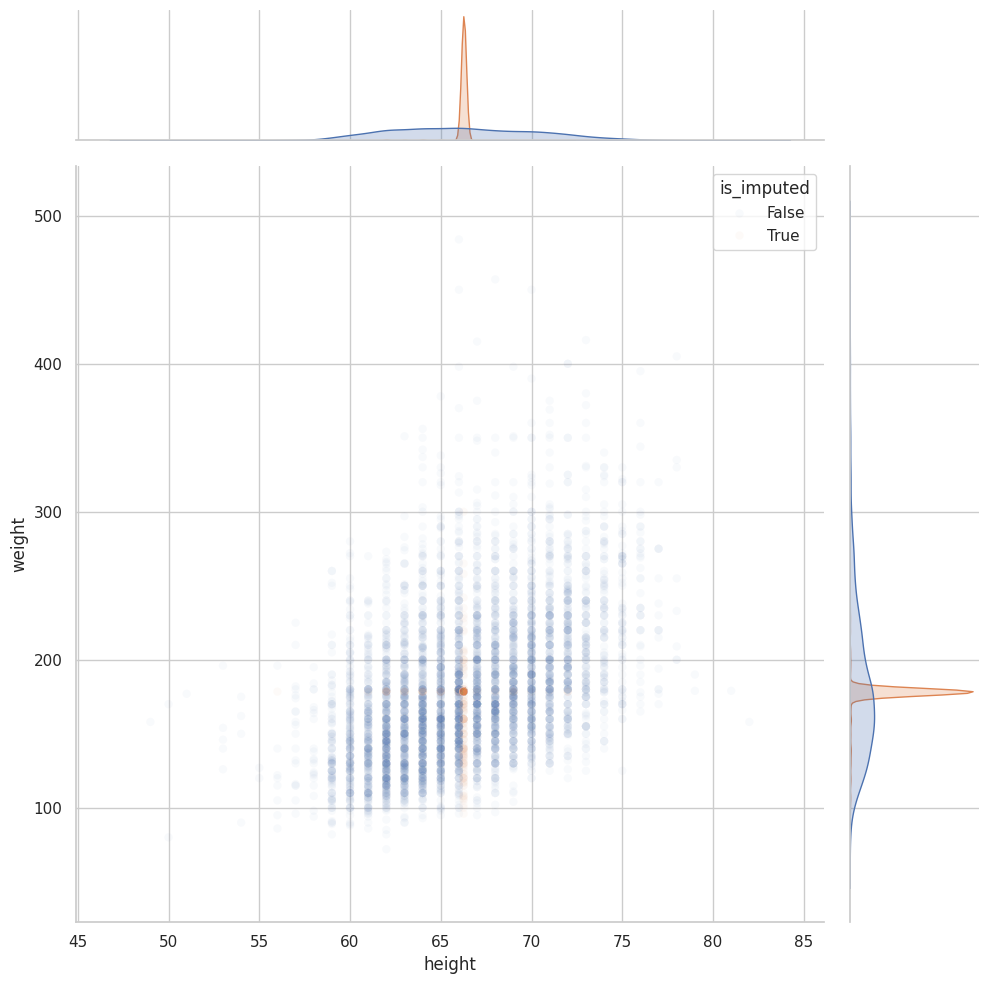

In [102]:
(
    nhanes_df
    .select_columns('height', 'weight')
    .missing.bind_shadow_matrix(True, False, suffix='_imp')
    .assign(
        height = lambda df : df.height.fillna(value= df.height.mean()),
        weight = lambda df : df.weight.fillna(value= df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
        show_marginal = True,
        height = 10,
        alpha=1/30
    )
)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

In [103]:
(
    nhanes_df
    .select_columns('height', 'weight')
    # .fillna(method = 'ffill')
    .ffill()
)

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [104]:
(
    nhanes_df
    .select_columns('height', 'weight')
    # .fillna(method = 'ffill')
    .bfill()
)

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [105]:
(
    nhanes_df
    # seleccionamos las variables. Hay dos categoricas y tres numericas
    .select_columns('weight', 'height', 'gender', 'diabetes', 'general_health_condition')
    # ordenamos los grupos segun nuestro interes 
    # para este caso, primero el genero, seguido de diabetes, su estado de salud y finalmente la altura
    .sort_values(
        by = ['gender', 'diabetes', 'general_health_condition', 'height'],
        ascending = True
    )# realizamos la imputacion con el metodo transform
    .transform_column(
        'weight',   # variable de interes
        lambda x: x.ffill(),    # imputacion hacia adelante
        elementwise = False     # pasa una serie y no un unico valor
    )
)

## De esta manera estamos garantizando que la imputacion esta tomando valores adecuados para cada dominio. 
# Sin embargo, puede ocurrir que al traerse el valor antecesor se obtenga un valor de otro dominio generando ruido en los datos. Para ello 
# se utiliza la funcion groupby lo cual permite agrupar los datos 
# por las variables categoricas y luego ordenarlos por las variables numericas para asi realizar la imputacion y evitar este problema.

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,weight,height,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,115.0,56.0,Female,0,Excellent
94187.0,130.0,59.0,Female,0,Excellent
95289.0,162.0,59.0,Female,0,Excellent
97967.0,130.0,59.0,Female,0,Excellent
99125.0,105.0,59.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,290.0,74.0,Male,1,NaN
96954.0,175.0,NaN,Male,1,NaN
97267.0,175.0,NaN,Male,1,NaN


In [115]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ['height','weight'],
        ascending = True
    )
    .groupby(['gender', 'diabetes', 'general_health_condition'])
    .apply(lambda df: df[['height', 'weight']].ffill())
    .reset_index()
)


/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_5971/3494447085.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[['height', 'weight']].ffill())


,gender,diabetes,general_health_condition,SEQN,height,weight
0,Female,0,Excellent,94421.0,56.0,115.0
1,Female,0,Excellent,101420.0,59.0,98.0
2,Female,0,Excellent,99125.0,59.0,105.0
3,Female,0,Excellent,100637.0,59.0,110.0
4,Female,0,Excellent,101326.0,59.0,119.0
...,...,...,...,...,...,...
5792,Male,1,Very good,101046.0,75.0,219.0
5793,Male,1,Very good,95553.0,75.0,225.0
5794,Male,1,Very good,94093.0,75.0,268.0
5795,Male,1,Very good,99068.0,82.0,158.0


/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_5971/4257873055.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[['height', 'weight','weight_NA', 'height_NA']].ffill())


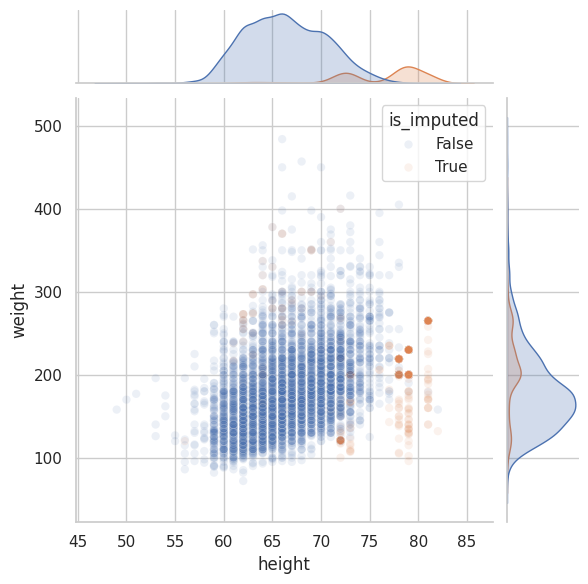

In [128]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .pipe(
        lambda df : (
              pd.concat(objs=[df, df.isna().add_suffix('_NA').select_columns('weight_NA', 'height_NA')], axis='columns')
        )
    )
    .sort_values(
        by = ['height','weight'],
        ascending = True
    )
    .groupby(['gender', 'diabetes', 'general_health_condition'])
    .apply(lambda df: df[['height', 'weight','weight_NA', 'height_NA']].ffill())
    .reset_index()
    [['height', 'weight', 'height_NA', 'weight_NA']]
    .assign(is_imputed=lambda df: df['height_NA'] | df['weight_NA'])
    .pipe(lambda df: (sns.jointplot(data=df, x='height', y='weight', hue="is_imputed", alpha=1/10)))
    )

/home/juanme/Desktop/curso-datos-faltantes-imputacion/.venv/lib/python3.11/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/tmp/ipykernel_5971/2815598526.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[['height', 'weight','weight_NA', 'height_NA']].ffill())


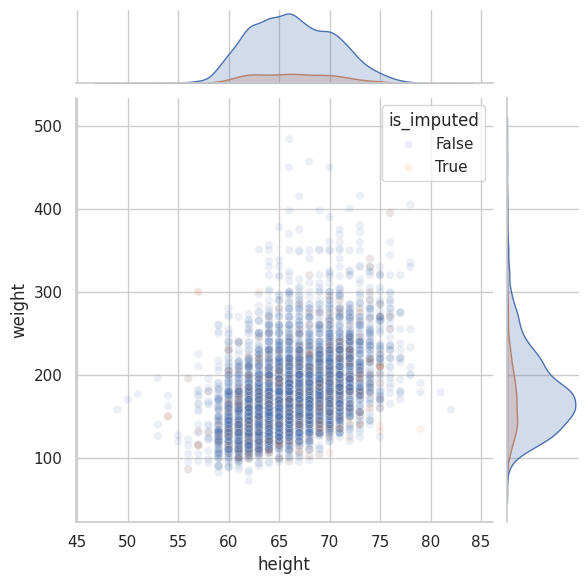

In [127]:
##Muy útil la recomendación a la hora de hacer la
# imputación hacia adelante organizar por datos o grupos similares, de esta manera los datos reemplazados se parecen a sus semejantes.

(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .pipe(
        lambda df : (
              pd.concat(objs=[df, df.isna().add_suffix('_NA').select_columns('weight_NA', 'height_NA')], axis='columns')
        )
    )

    .groupby(['gender', 'diabetes', 'general_health_condition'])
    .apply(lambda df: df[['height', 'weight','weight_NA', 'height_NA']].ffill())
    .reset_index()
    [['height', 'weight', 'height_NA', 'weight_NA']]
    .assign(is_imputed=lambda df: df['height_NA'] | df['weight_NA'])
    .pipe(lambda df: (sns.jointplot(data=df, x='height', y='weight', hue="is_imputed", alpha=1/10)))
    )

## Imputación por interpolación

## Imputación por algoritmo de vecinos más cercanos (KNN)

### Ordenamiento por cantidad de variables faltantes

## Imputación basada en modelos

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

## Transformación inversa de los datos

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [ ]:
session_info.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>